In [1]:
import pandas as pd
from scipy.io import arff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import np_utils
%tensorflow_version 2.x

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import TimeDistributed
from keras import layers

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import History
import copy
sns.set(font_scale=1.2)


Using TensorFlow backend.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
db=arff.loadarff('EES.arff')


In [0]:
df = pd.DataFrame(db[0])
column = pd.to_numeric(df['eyeDetection'])
df = df.drop(['eyeDetection'],axis=1)
df.insert(14,'eyeDetection',column)

In [0]:
new_df = np.array(df)

In [0]:
# regularize outlier
for i in range(len(new_df)):
  for j in range(len(new_df[i])-1):
    if new_df[i][j]>4800:
      new_df[i][j] = new_df[i-1][j]
    if new_df[i][j]<3800:
      new_df[i][j] = new_df[i-1][j]

X_data = new_df[:,0:14]
Y_data = new_df[:,14]



In [0]:
#Extract data for LSTM
def new_data_set(dataset,forward_step,time_step,cut_change):
  new_data_set = []
  end_index = forward_step + time_step
  start_index = 0
  while end_index < len(dataset):
    data_piece = dataset[start_index:end_index,:]
    if cut_change:
      if int(data_piece[0][-1]) == int(data_piece[-1][-1]):
        new_data_set.append(data_piece)
      else:
        start_index += time_step
        end_index += time_step
        continue
    else:
      new_data_set.append(data_piece)
    start_index += time_step
    end_index += time_step
  return np.array(new_data_set)


X_train = new_data_set(new_df[0:4900,:],25,25,False)
X_validation = new_data_set(new_df[4900:9800,:],25,25,False)
X_test = new_data_set(new_df[9800:14700,:],25,25,False)


In [0]:
#get data in shape
y_train = np.array([i[-1][-1] for i in X_train])
y_validation = np.array([i[-1][-1] for i in X_validation])
y_test = np.array([i[-1][-1] for i in X_test])
X_train = X_train[:,:,0:14]
X_validation = X_validation[:,:,0:14]
X_test = X_test[:,:,0:14]
length = y_train.shape[0]
y_train = y_train.reshape(length,1)
y_validation = y_validation.reshape(length,1)
y_test = y_test.reshape(length,1)

In [0]:
#transfrom y into hot vector
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train,2)
y_test = to_categorical(y_test,2)
y_validation = to_categorical(y_validation,2)

In [20]:
#model setup and learning
model = Sequential()
model.add(LSTM(128,activation='tanh',input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
model.add(LSTM(32,activation='relu',return_sequences=False))
model.add(Dense(2,activation = 'sigmoid'))
adam = Adam(lr=1e-4,beta_1=0.9, beta_2=0.999,decay=1e-06)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model.compile(loss='mae', optimizer=adam, metrics=['accuracy'])
history=model.fit(X_train,y_train, epochs=60, batch_size=32, callbacks=[chk],validation_data=[X_validation,y_validation])

Train on 194 samples, validate on 194 samples
Epoch 1/60
194/194 [==============================] - 3s 17ms/step - loss: 0.4993 - acc: 0.5103 - val_loss: 0.4786 - val_acc: 0.6392

Epoch 00001: val_acc improved from -inf to 0.63918, saving model to best_model.pkl
Epoch 2/60
194/194 [==============================] - 1s 4ms/step - loss: 0.4976 - acc: 0.5103 - val_loss: 0.4743 - val_acc: 0.6392

Epoch 00002: val_acc did not improve from 0.63918
Epoch 3/60
194/194 [==============================] - 1s 4ms/step - loss: 0.4969 - acc: 0.5103 - val_loss: 0.4689 - val_acc: 0.6392

Epoch 00003: val_acc did not improve from 0.63918
Epoch 4/60
194/194 [==============================] - 1s 4ms/step - loss: 0.4969 - acc: 0.5103 - val_loss: 0.4700 - val_acc: 0.6392

Epoch 00004: val_acc did not improve from 0.63918
Epoch 5/60
194/194 [==============================] - 1s 4ms/step - loss: 0.4972 - acc: 0.5103 - val_loss: 0.4660 - val_acc: 0.6392

Epoch 00005: val_acc did not improve from 0.63918
Epoch

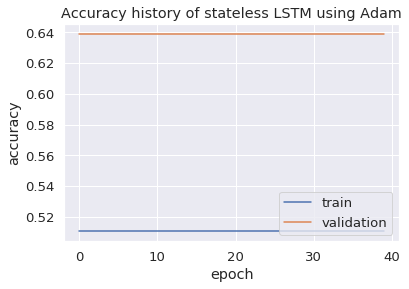

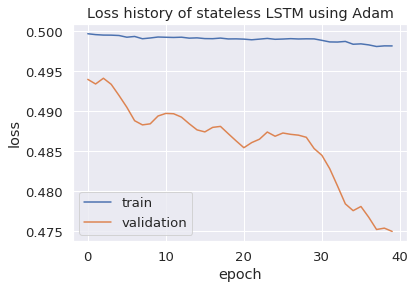

In [11]:
  # summarize history for acc
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Accuracy history of stateless LSTM using Adam')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='lower right')
  plt.savefig('adam_acc_less')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss history of stateless LSTM using Adam')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='lower left')
  plt.savefig('adam_loss_less')
  plt.show()